# **Akari solver**

**After wikipedia:** https://en.wikipedia.org/wiki/Light_Up_(puzzle)

Light Up (Japanese: 美術館 bijutsukan, art gallery), also called Akari, is a binary-determination logic puzzle published by Nikoli. As of 2011, three books consisting entirely of Light Up puzzles have been published by Nikoli.

**Rules**

Light Up is played on a rectangular grid of white and black cells. The player places light bulbs in white cells such that no two bulbs shine on each other, until the entire grid is lit up. A bulb sends rays of light horizontally and vertically, illuminating its entire row and column unless its light is blocked by a black cell. A black cell may have a number on it from 0 to 4, indicating how many bulbs must be placed adjacent to its four sides; for example, a cell with a 4 must have four bulbs around it, one on each side, and a cell with a 0 cannot have a bulb next to any of its sides. An unnumbered black cell may have any number of light bulbs adjacent to it, or none. Bulbs placed diagonally adjacent to a numbered cell do not contribute to the bulb count.

**Example board (hard):**

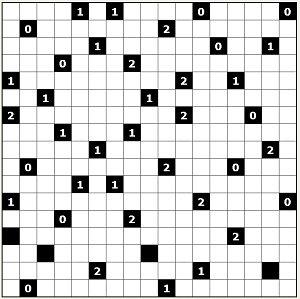

In [ ]:
# imports
from itertools import combinations, chain, product
import numpy as np
import copy
from PIL import Image, ImageDraw, ImageFont

In [ ]:
# Example game board converted to an array

# field with restrictions around it = 0, 1, 2, 3, 4
# blck neutral field = 5
# empty field = 6
# field with a dot (light bulb) = 7
# field shaded by the dot = 8
# blocked field (cannot have a dot, but its not shaded) = 9

example = [[6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 0, 6, 6, 6, 6, 0],
           [6, 0, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6], 
           [6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 0, 6, 6, 1, 6], 
           [6, 6, 6, 0, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6], 
           [1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 1, 6, 6, 6], 
           [6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6], 
           [2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 0, 6, 6], 
           [6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6], 
           [6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6],
           [6, 0, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 0, 6, 6, 6], 
           [6, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 
           [1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 0],
           [6, 6, 6, 0, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6], 
           [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6], 
           [6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6], 
           [6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 1, 6, 6, 6, 5, 6], 
           [6, 0, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6]]

# coverted to numpy array
example = np.asarray(example)

In [ ]:
def paint_result(brd):
  ''' Creates a graphical representation of the final result '''

  # Create an empty canvas
  canvas = Image.new('RGB', 
                     (1+brd.shape[0]*21, 
                      1+brd.shape[1]*21),
                     'black')

  # Paste patches based on the input array
  for row in range(len(brd)):
      for col in range(len(brd[row])):
        
        if brd[row][col] in [0, 1, 2, 3, 4]:
          text = str(brd[row][col])
          im = Image.new("RGB",(20,20),"black")
          draw = ImageDraw.Draw(im)
          w, h = draw.textsize(text)
          draw.text(((20-w)/2,(20-h)/2), text, fill="white")
          canvas.paste(im, (1+col*21, 1+row*21))

        elif brd[row][col] == 5:
          im = Image.new("RGB",(20,20),"black")
          draw = ImageDraw.Draw(im)
          canvas.paste(im, (1+col*21, 1+row*21))

        elif brd[row][col] == 6:
          im = Image.new("RGB",(20,20),"white")
          draw = ImageDraw.Draw(im)
          canvas.paste(im, (1+col*21, 1+row*21))

        elif brd[row][col] == 7:
          im = Image.new("RGB",(20,20),(255, 255, 150))
          draw = ImageDraw.Draw(im)
          draw.ellipse((5,5,15,15), fill="yellow", outline=(0, 0, 0))
          canvas.paste(im, (1+col*21, 1+row*21))
        
        else:
          im = Image.new("RGB",(20,20),(255, 255, 150))
          draw = ImageDraw.Draw(im)
          canvas.paste(im, (1+col*21, 1+row*21))

  display(canvas)

In [ ]:
def crawler(brd, start_positions, append_values, pass_values):
  ''' Based on each start position checks the cross pattern, appends 
  values from apend_values list, passes over values from pass_values list
  and breaks iteration over a cross arm if finds anything else.
  Returns a list for each starting position 
  '''
  
  output = []
  for i in start_positions:
    position_output = []

    step = 1
    while (i[0]+step) < len(brd):
      value = brd[i[0]+step][i[1]]
      if value in append_values: position_output.append((i[0]+step,i[1]))
      elif value in pass_values: pass
      else: break
      step += 1

    step = 1
    while (i[0]-step) >= 0:
      value = brd[i[0]-step][i[1]]
      if value in append_values: position_output.append((i[0]-step,i[1]))
      elif value in pass_values: pass
      else: break
      step += 1

    step = 1
    while (i[1]+step) < len(brd[0]):
      value = brd[i[0]][i[1]+step]
      if value in append_values: position_output.append((i[0],i[1]+step))
      elif value in pass_values: pass
      else: break
      step += 1

    step = 1
    while (i[1]-step) >= 0:
      value = brd[i[0]][i[1]-step]
      if value in append_values: position_output.append((i[0],i[1]-step))
      elif value in pass_values: pass
      else: break
      step += 1

    output.append(position_output)

  return output

In [ ]:
def crd_list(brd, nums):
  ''' Returns array locations for each numbers from a list '''

  output = []
  for i in nums:
    num = np.where(brd == i)
    zipping = list(zip(num[0], num[1]))
    output.extend(zipping)

  return output

In [ ]:
def around(brd, crd):
  ''' Returns spots around a single position crd == (x, y) 
  only within an array.
  '''
  
  # Generate coordinates sub-list of spaces around target
  all_positions = [[crd[0]-1, crd[1]], [crd[0], crd[1]-1], 
                   [crd[0]+1, crd[1]], [crd[0], crd[1]+1]]

  # Remove possitions outside the array
  output = []
  for i in all_positions:
    if (i[0] >= 0 and i[0] < len(brd[0]) and
        i[1] >= 0 and i[1] < len(brd)):
      output.append(i)

  return output

In [ ]:
def number_around(brd, number, crd_list):
  ''' Returns only position of a specific number from a list of coordinates '''

  output = []
  for i in crd_list:
    if brd[i[0]][i[1]] == number: output.append(i)
  
  return output

In [ ]:
def iterate(brd):
  ''' Find a number with the least number of combinations around it 
  returns the location of the number and all of the combinations
  '''

  # Position of all of the numbers 0-4, output: [(1, 2), (2, 3)]
  number_positions = crd_list(brd, [0, 1, 2, 3, 4])
  
  # Reiterate the list above to check which numbers they contain
  numbers = []
  for i in number_positions: 
    numbers.append(brd[i[0]][i[1]])
 
  # Find empty positions '6' and number of dots '7' around a position
  six_around, seven_around = [], []
  for i in number_positions:
    in_matrix = around(brd, i)
    six_around.append(number_around(brd, 6, in_matrix))
    seven_around.append(len(number_around(brd, 7, in_matrix)))

  # Delete empty lists of completed numbers
  while True:
    if (len(min(six_around, key=len, default=[])) != 0 or 
        len(six_around) == 0): break
    ind = six_around.index(min(six_around, key=len))
    del (six_around[ind], seven_around[ind], 
         number_positions[ind], numbers[ind])

  # After all numbers (0,1,2,3,4) are completed start with blocked '9' 
  if len(six_around) == 0 and len(crd_list(brd, [9])) != 0:
    remaining_9_pos = crd_list(brd, [9])
    comb_for_9 = crawler(brd, remaining_9_pos, [6], [8, 9])
    shortest = comb_for_9.index(min(comb_for_9, key=len))
    return ([], [comb_for_9[shortest]])


  # After all numbers and blocked positions 
  # are completed find remaining empty spots
  if len(six_around) == 0 and len(crd_list(brd, [9])) == 0:
    remaining_6_pos = crd_list(brd, [6])
    out_comb = []
    for i in remaining_6_pos: out_comb.append([i])
    return ([], out_comb)

  # Create all of the combinations for each number
  comb = []
  for i in range(len(six_around)):
    number = brd[number_positions[i][0]][number_positions[i][1]]
    dots = seven_around[i]
    comb.append(list(combinations(six_around[i], (number - dots))))
  shortest = comb.index(min(comb, key=len))

  return (number_positions[shortest], comb[shortest])

In [ ]:
def colour(brd, position, comb):
  ''' adds dots, shade and locks on the board input: board, 
  position of the POI and combination of dots '7' around it
  '''

  board = copy.deepcopy(brd)

  # Enter the selected dot combination
  for i in comb: board[i[0]][i[1]] = 7
  
  # Shade positions radiating from dots
  shade_positions = crawler(board, comb, [6, 9], [8])
  for pos in shade_positions: 
    for i in pos: board[i[0]][i[1]] = 8

  # Block all remaining empty positions around a number
  if len(position) != 0:
    all_around = around(board, position)
    remaining_empty = number_around(board, 6, all_around)
    for i in remaining_empty: board[i[0]][i[1]] = 9

  return board

In [ ]:
def verify(brd):
  ''' Verify that the current state of the board is correct '''

  # Check if each number has solvable number number or dots/empty around 
  number_positions = crd_list(brd, [0, 1, 2, 3, 4])
 
  for position in number_positions:
    space_around = around(brd, position)
    six = len(number_around(brd, 6, space_around))
    seven = len(number_around(brd, 7, space_around))
    number = brd[position[0]][position[1]]

    if seven > number or (six + seven) < number: 
      return False

  # Check if all of the blocked spots '9' has empty spot in view
  number_positions_9 = crd_list(brd, [9])
  check_9 = crawler(brd, number_positions_9, [6], [8, 9])
  for i in check_9:
    if len(i) == 0: return False

  return True

In [ ]:
def solve(brd):
  ''' Main function solving the puzzle'''

  # Check if the board is completed
  if len(crd_list(brd, [6, 9])) == 0: 
    paint_result(brd)
    return True

  board = copy.deepcopy(brd)
  position, comb = iterate(board)

  for i in comb:
    new_board = colour(board, position, i)
    if verify(new_board):
      if solve(new_board): return True

  return False

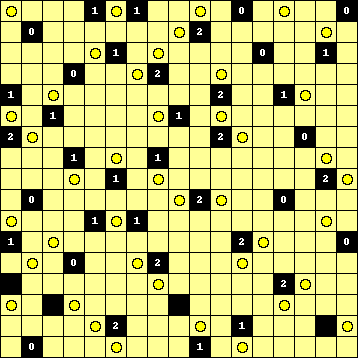

True

In [ ]:
solve(example)